In [1]:
#Importo librerías necesarias
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline

#Cuestiones previas:
###1. La forma de guardar la información de las masas es la siguiente:
+ Cada una tiene dos componentes: un vector $r$ (que contiene posición en $\hat{\textbf{i}}$ y $\hat{\textbf{j}}$) y un vector $v$ (que contiene velocidad en $\hat{\textbf{i}}$ y $\hat{\textbf{j}}$).
+ El array Y contiene la información de **todas** las masas en cuestión. El orden de la información contenida en este array es: [$r_1,v_1,r_2,v_2, \dots ,r_n,v_n$]. Definidos $r$ y $v$ como se explicó en el punto anterior.

###2. Utilizamos la siguiente fórmula para definir la interacción gravitacional (Asumiendo $G = 1$):

$$\\ m_i \dfrac{d^2x}{dt^2} = - \sum_{i \neq j} \dfrac{m_i m_j (x_i - x_j)}{r^3_{ij}}\\$$
$$i = 1, \dots , N$$

###3. Utilizamos el método de Runge-Kutta de orden 4 para resolver las ecuaciones diferenciales de movimiento. Recordando que este se basa en que:

$$\dfrac{d}{dt} Y(t) = f(Y)$$

###4. Todo lo aquí hecho se basa en la información tomada de las fuentes: [1](http://www14.in.tum.de/konferenzen/Jass05/courses/2/Lapshin/Lapshin_paper.pdf), [2](http://radio.astro.gla.ac.uk/a1dynamics/pw/code/simple-3-body.py), [3](https://github.com/ComputoCienciasUniandes/MetodosComputacionales/blob/master/slides/2015-V/10-ODE.ipynb).

###5. A conitnuación se definen las funciones a utilizar:

In [2]:
#Basados en el inciso (2) definimos la función de m*a. Que para el método Runge-Kutta sería la velocidad.
def f(Y):
    info = [] #Toda la información se guarda en esta variable local, que al final del método es retornada.
    for i in range(0,len(Y),2): #Este ciclo recorre cada una de las masas.
        v = 0
        #Este ciclo encuentra la atracción que siente cada una de las masas efectuada por las demás.
        for j in range(0,len(Y),2):
            if (i != j): #Utilizamos esta condición para evitar calcular la fuerza que una masa ejerce sobre sí misma.
                v -= ((Y[i] - Y[j]) / norm(Y[i] - Y[j])**3)
        info.extend((Y[i+1],v))
    return(np.array(info))

In [28]:
#Basados en las fuentes 2 y 3 implementamos el método de Runge-Kutta de orden 4.
def runge_kutta_orden4(dt,Y):
    #Resolvemos las ecuaciones de movimiento con Runge-Kutta orden 4.
    K1 = dt*f(Y)
    K2 = dt*f(Y + (1/2.*K1))
    K3 = dt*f(Y + (1./2.*K2))
    K4 = dt*f(Y + K3)
    dy = 1/6.*K1 + 1/3.*K2 + 1/3.*K3 + 1/6.*K4
    #Asignamos los nuevos valores encontrados al vector inicial.
    Y += dy

In [ ]:
#Debo re-implementar Runge-Kutta para poder ponerlo como lo quiere el profesorrr
chosenstep=one_Kutta4_step
numIter=100
Y=np.array([1.,0.,0.,1.])
tmax=2*np.pi
t=0.
Deltat=tmax/numIter
history=np.array([[t,Y[0],Y[1],Y[2],Y[3]]])
def one_Kutta4_step():
    global t
    global Deltat
    global Y
    K1 = f(Y)
    K2 = f(Y + Deltat*(1./2.*K1))
    K3 = f(Y + Deltat*(1./2.*K2))
    K4 = f(Y + Deltat*K3)
    Y+= Deltat * (1/6.*K1 + 1/3. * K2 + 1/3.*K3 + 1/6.*K4)
    t+= Deltat

In [29]:
#Definimos una función que llama varias veces el método de Runge-Kutta para efectuar la simulación.
def simulacion(numIter=100,periodo=1,Y=-1,**kwargs):
    if ((len(Y)%2) != 0):
        #Arroja error si no se pasa un Y, o el que se pasa no tiene el formato adecuado
        raise TypeError("Introduzca un Y válido")
    dt = periodo*0.01 #Se cuadra la escala de tiempo para que 1 periodo se ajuste al dt del método.
    history=np.array([Y]) #Este array contendrá la información luego de cada iteración con el fin de poder graficar.
    for iters in range(numIter):#Se ejecuta el método Runge-Kutta durante la cantidad de iteraciones propuestas
        runge_kutta_orden4(dt,Y)
        history=np.append(history,[Y],axis=0)
    return (history)

In [30]:
#Definimos una función que grafica basados en los datos arrojados por la simulación
#Se pasa por parámetro la historia de la simulación y la trayectoria de la masa que se quiere graficar
#Si no se pasa ninguna masa por parámetro (o se iguala a 0) muestra la trayectoria de todas las masas
def graficador(history,masa=0,**args):
    if (masa == 0):
        plt.figure(figsize=(14,4))
        plt.title("Kutta Orden 4")
        plt.axis('equal')
        #plt.xlim(-0.4,0.4)
        #plt.ylim(-0.1,0.1)
        for i in range(0,len(Y),2):
            plt.scatter(history[:,i][:,0],history[:,i][:,1],s=1)
            plt.scatter(history[:,i][:,0][0],history[:,i][:,1][0],s=30,label="Inicio",color='blue')
            #plt.scatter(history[:,i][:,0][int(len(history)-1)],history[:,i][:,1][int(len(history)-1)],s=30,label="Fin",color='red')
        plt.legend(loc=0)
        plt.xlabel('Posición $x$')
        plt.ylabel('Posición $y$')
        plt.title('Trayectorias de las masas',fontsize=15)
        plt.show()
    else:
        plt.figure(figsize=(14,4))
        plt.title("Kutta Orden 4")
        plt.axis('equal')
        #plt.xlim(-0.4,0.4)
        #plt.ylim(-0.1,0.1)
        plt.scatter(history[:,int((masa-1)*2)][:,0],history[:,int((masa-1)*2)][:,1],s=1)
        plt.scatter(history[:,int((masa-1)*2)][:,0][0],history[:,int((masa-1)*2)][:,1][0],s=30,label="Inicio",color='blue')
        plt.scatter(history[:,int((masa-1)*2)][:,0][int(len(history)-1)],history[:,int((masa-1)*2)][:,1][int(len(history)-1)],s=30,label="Fin",color='red')
        plt.legend(loc=0)
        plt.xlabel('Posición $x$')
        plt.ylabel('Posición $y$')
        plt.title('Trayectoria de $m_{%d}$'%masa,fontsize=15)
        plt.show()

##Punto 1) 3-Coreografía

In [97]:
#Defino las ecuaciones iniciales
a = 0.24250109
b = -0.0607718825
c = 0.93240737
d = 0.86473146

#Se ordena la información de cada masa y la del total en Y basados en la explicación inicial.
r1 = np.array([a,b])
r2 = np.array([-a,-b])
r3 = np.array([0,0])

v1 = np.array([c,d])
v2 = np.array([c,d])
v3 = np.array([-2*c,-2*d])

Y = np.array([r1,v1,r2,v2,r3,v3])

In [86]:
history=simulacion(numIter=100,Y=Y,periodo=0.8)

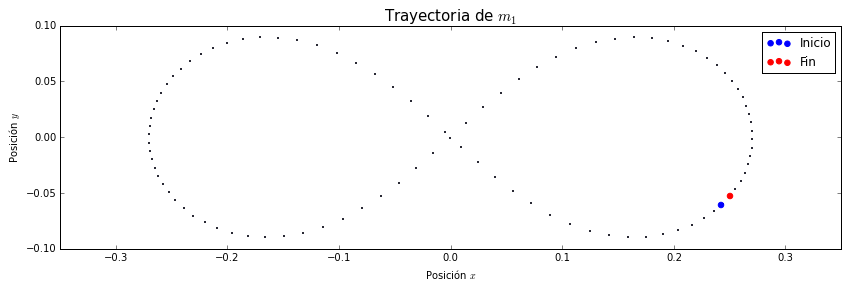

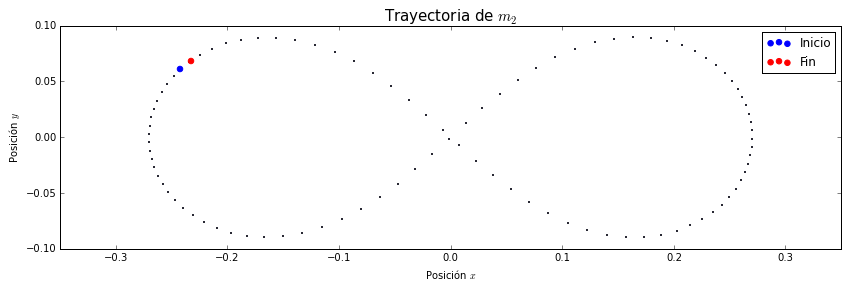

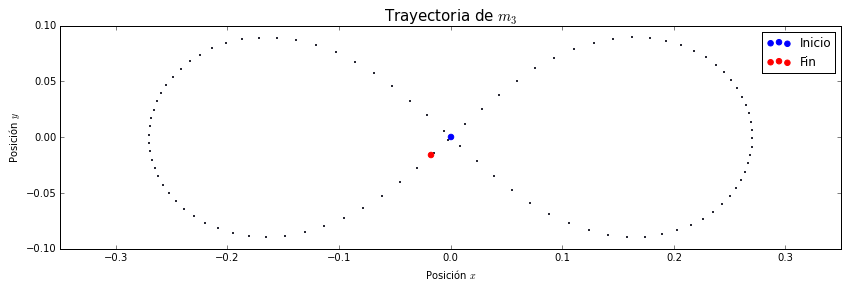

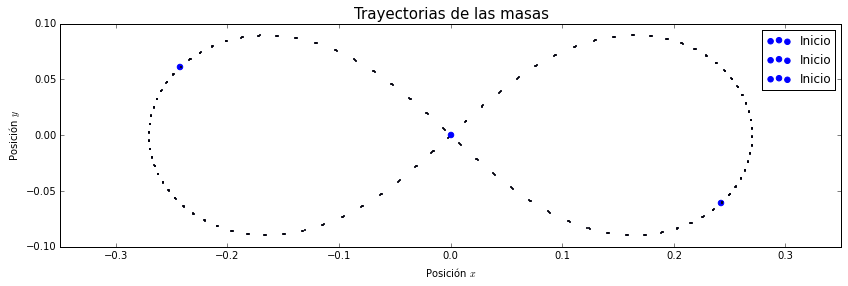

In [87]:
lalala = 1
graficador(history,lalala)

lalala = 2
graficador(history,lalala)

lalala = 3
graficador(history,lalala)

lalala = 0
graficador(history,lalala)

In [98]:
rango = np.linspace(0.79,0.81,100)

In [102]:
for i in rango:
    Y = np.array([r1,v1,r2,v2,r3,v3])
    history=simulacion(numIter=100,Y=Y,periodo=i)
    inicio = np.array([history[:,0][:,0][0],history[:,0][:,1][0]])
    fin = np.array([history[:,0][:,0][int(len(history)-1)],history[:,0][:,1][int(len(history)-1)]])
    print(inicio)
    print(fin)
    print("")
    
history=simulacion(numIter=100,Y=Y,periodo=0.5)
inicio = np.array([history[:,0][:,0][0],history[:,0][:,1][0]])
fin = np.array([history[:,0][:,0][int(len(history)-1)],history[:,0][:,1][int(len(history)-1)]])

[ 0.24250109 -0.06077188]
[ 0.24181623 -0.06139279]

[ 0.24250109 -0.06077188]
[ 0.24200704 -0.06121869]

[ 0.24250109 -0.06077188]
[ 0.24219705 -0.06104439]

[ 0.24250109 -0.06077188]
[ 0.24238626 -0.06086989]

[ 0.24250109 -0.06077188]
[ 0.24257469 -0.06069518]

[ 0.24250109 -0.06077188]
[ 0.24276232 -0.06052028]

[ 0.24250109 -0.06077188]
[ 0.24294916 -0.06034519]

[ 0.24250109 -0.06077188]
[ 0.24313522 -0.0601699 ]

[ 0.24250109 -0.06077188]
[ 0.24332049 -0.05999442]

[ 0.24250109 -0.06077188]
[ 0.24350497 -0.05981875]

[ 0.24250109 -0.06077188]
[ 0.24368867 -0.0596429 ]

[ 0.24250109 -0.06077188]
[ 0.24387159 -0.05946685]

[ 0.24250109 -0.06077188]
[ 0.24405373 -0.05929063]

[ 0.24250109 -0.06077188]
[ 0.2442351  -0.05911423]

[ 0.24250109 -0.06077188]
[ 0.24441569 -0.05893764]

[ 0.24250109 -0.06077188]
[ 0.2445955  -0.05876088]

[ 0.24250109 -0.06077188]
[ 0.24477454 -0.05858395]

[ 0.24250109 -0.06077188]
[ 0.24495282 -0.05840684]

[ 0.24250109 -0.06077188]
[ 0.24513032 -0.0582

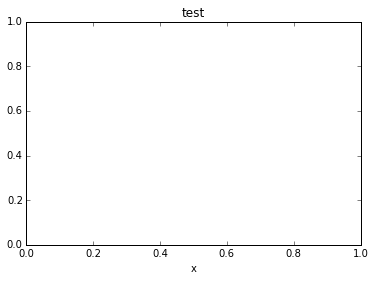

In [33]:
import matplotlib.animation as animation

def update_line(num, data, line):
    line.set_data(data[...,:num])
    return line,

fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
    interval=50, blit=True)

/usr/local/lib/python3.4/dist-packages/matplotlib/animation.py:742: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


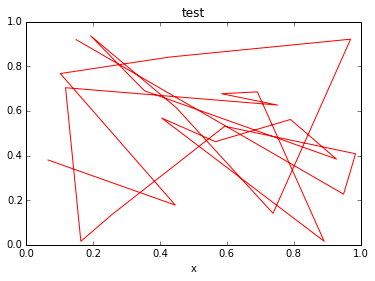

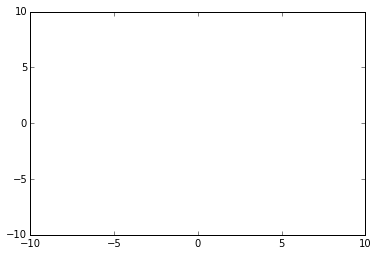

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def update_line(num, data, line):
    line.set_data(data[...,:num])
    return line,

fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
    interval=50, blit=True)
line_ani.save('lines.mp4')

fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
    blit=True)
#im_ani.save('im.mp4', metadata={'artist':'Guido'})

plt.show()

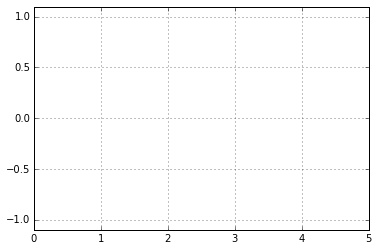

In [35]:
def data_gen():
    t = data_gen.t
    cnt = 0
    while cnt < 1000:
        cnt+=1
        t += 0.05
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)
data_gen.t = 0

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_ylim(-1.1, 1.1)
ax.set_xlim(0, 5)
ax.grid()
xdata, ydata = [], []
def run(data):
    # update the data
    t,y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=10,
    repeat=False)
plt.show()

In [37]:
4*3.5

14.0

In [120]:
len(history)

101

In [121]:
history[:,0]

array([[[ 0.24250109, -0.06077188],
        [ 0.93240737,  0.86473146],
        [-0.24250109,  0.06077188],
        [ 0.93240737,  0.86473146],
        [ 0.        ,  0.        ],
        [-1.86481474, -1.72946292]],

       [[ 0.24521195, -0.05815696],
        [ 0.87514827,  0.87817817],
        [-0.23961563,  0.06334298],
        [ 0.99154395,  0.848914  ],
        [-0.00559632, -0.00518602],
        [-1.86669222, -1.72709217]],

       [[ 0.24775386, -0.05550491],
        [ 0.81976845,  0.88952513],
        [-0.23654998,  0.06586271],
        [ 1.05252879,  0.83043521],
        [-0.01120388, -0.01035779],
        [-1.87229724, -1.71996034]],

       ..., 
       [[-0.05853542, -0.05004535],
        [-2.03264514, -1.47094628],
        [ 0.26283269, -0.03313447],
        [ 0.43285984,  0.93091771],
        [-0.20429727,  0.08317981],
        [ 1.5997853 ,  0.54002857]],

       [[-0.06467536, -0.05437503],
        [-2.06069625, -1.41449708],
        [ 0.26406964, -0.03033954],
       

In [95]:
for i in rango:
    print (i)

0.79
0.790202020202
0.790404040404
0.790606060606
0.790808080808
0.79101010101
0.791212121212
0.791414141414
0.791616161616
0.791818181818
0.79202020202
0.792222222222
0.792424242424
0.792626262626
0.792828282828
0.79303030303
0.793232323232
0.793434343434
0.793636363636
0.793838383838
0.79404040404
0.794242424242
0.794444444444
0.794646464646
0.794848484848
0.795050505051
0.795252525253
0.795454545455
0.795656565657
0.795858585859
0.796060606061
0.796262626263
0.796464646465
0.796666666667
0.796868686869
0.797070707071
0.797272727273
0.797474747475
0.797676767677
0.797878787879
0.798080808081
0.798282828283
0.798484848485
0.798686868687
0.798888888889
0.799090909091
0.799292929293
0.799494949495
0.799696969697
0.799898989899
0.800101010101
0.800303030303
0.800505050505
0.800707070707
0.800909090909
0.801111111111
0.801313131313
0.801515151515
0.801717171717
0.801919191919
0.802121212121
0.802323232323
0.802525252525
0.802727272727
0.802929292929
0.803131313131
0.803333333333
0.8035353

In [16]:
len(history)

101

In [15]:
print(r'$\pi$')

$\pi$


In [34]:
Y

array([[ 0.26341276,  0.03185875],
       [-0.41404501,  0.93160071],
       [-0.061328  ,  0.05204311],
       [ 2.04541394, -1.44592816],
       [-0.20208475, -0.08390187],
       [-1.63136893,  0.51432746]])

In [36]:
Y

array([[ 0.24250109, -0.06077188],
       [ 0.93240737,  0.86473146],
       [-0.24250109,  0.06077188],
       [ 0.93240737,  0.86473146],
       [ 0.        ,  0.        ],
       [-1.86481474, -1.72946292]])